# satFBA
A stoichiometric approximation to a kinetic model. Briefly, we assume all internal fluxes $v_i$ (splitted in their forward and backward components) to run at steady state with enzyme mass cost:

$e_i= \frac{W_i}{k^i_{app}} v_i$

where $M_i$ is the molecular weight of enzyme $i$ and the apparent turnover numbers $k^i_{app}$ are assumed to be fixed. In addition, we consider exact kinetics of substrate uptake (flux $v_{up}), that is:

$v_{up}=e_{up} \hspace{0.2cm} k^{up}_{app}=e_{up} \hspace{0.2cm}k^{up}_{cat} \hspace{0.2cm}\kappa (s,p)$

where the saturation function $\kappa (s,p) \in (0,1)$ governs the efficiency of enzymatic subtrate transport and is assumed to be dependent on the external substrate concentration ($s$) and a vector of kinetic parameters ($p$). Since the kinetic function $\kappa (s,p)$ is assumed to be invertible, it follows that for any $k^{up}_{app} \in (0,k^{up}_{cat})$ the corresponding external concentration $s$ is uniquely determined. Hence, we can simply solve the model with enzymatic constraints parametrically (with respect to k^{up}_{cat}) and then transform the optimal parametric solution back into $s$ coordinates according to a kinetic law of choice.

The approach is presented in:

Müller S, Regensburger G, Steuer R. Biochem Soc Trans. 2015 Dec;43(6):1195-200. doi: 10.1042/BST20150156. PMID: 26614660.

### Preliminaries

In [1]:
import cobra
import sys
import pandas as pd
import numpy as np
sys.path.append('../utils')
from fba_utils import *
import matplotlib.pyplot as plt

In [2]:
model=cobra.io.load_json_model('../Model/Escherichia_coli_iCH360.json')
#We remove the standard glucose uptake bound
model.reactions.EX_glc__D_e.lower_bound=-1000

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-25


We consider the D-glucose transport via PEP:Pyr PTS (GCLptspp), which couples glucose uptake and phosphorilation to G6P (this is mediated by PEP dephosphorilation to pyruvate). The transport system involves two enzymes (EI, made up of subunits ptsG and crr, and EII, made up by polypeptide ptsI) and the p-carrying protein Hpr. I couldn't find much kinetic data on the transporter system, but we can do some calculations to et some rough idea.

Assume the transporter to operate at saturation under excess media glucose conditions (that is, $k_{app} \approx k_{cat}$). Let $v^{up}_{max}$ be uptake flux under such saturating conditions. Then the enzyme mass cost for substrate uptake is estimated as:

$e_{up} \approx \frac{A_{up}}{v^{up}_{max}}$

where $A_{up}$ is the total abundance of the various polypeptides involved in the transport system (in g/gDW) under the assumed saturating conditions. I took such abundance data (measured in excess glucose conditions) from :

Schmidt, A., Kochanowski, K., Vedelaar, S. et al. The quantitative and condition-dependent Escherichia coli proteome. Nat Biotechnol 34, 104–110 (2016). https://doi.org/10.1038/nbt.3418



In [3]:
pts_abundance_df=pd.read_csv('pts_system_data.csv')
pts_abundance_df

,polypeptide,n,mw_da,mw_g_mmol,abundance_fg_cell,abundance_g_gdw,abundance_mmol_gdw
0,ptsG,2,50625.74752,50.625748,0.233,0.000778,0.000015
1,crr,1,18221.73165,18.221732,1.010,0.003380,0.000186
2,ptsI,2,63503.89517,63.503895,1.070,0.003570,0.000056


In [4]:
v_up_max=10 # e.g.10 mmol/gDW/h
A_up=np.sum(pts_abundance_df['abundance_g_gdw'].to_numpy()*pts_abundance_df['n'].to_numpy())
MW_up=np.sum(pts_abundance_df['mw_g_mmol'].to_numpy()*pts_abundance_df['n'].to_numpy())

e_up=A_up/v_up_max
k_cat_up=MW_up/e_up
print(f'Estimated enzyme mass cost of glucose uptake at saturating conditions: {e_up} g per unit flux')


Estimated enzyme mass cost of glucose uptake at saturating conditions: 0.0012076 g per unit flux


### satFBA across saturation conditions of the Uptake reaction

In [5]:
kapp_df=pd.read_csv('../Molecular_Crowding/kapp_w_mass_scaled.csv',index_col=0)

v_up_data={'id':'GLCptspp',
            'mw':MW_up,
            'kcat':k_cat_up,
            'dir':'fwd'}
d_P_max=A_up #how much to increase our proteomic constraint by
P_max_w_up=kapp_df.iloc[0]['enzyme_mass_bound']+d_P_max
kapps,sols=satFBA(model=model,
                   kapp_df=kapp_df,
                   P_max=P_max_w_up,
                   uptake_flux_data=v_up_data,
                   N=100)

Read LP format model from file C:\Users\marco\AppData\Local\Temp\tmp67xonvjk.lp
Reading time = 0.00 seconds
: 317 rows, 728 columns, 3152 nonzeros


c:\Users\marco\anaconda3\envs\met_mod2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Here we look at the results by looking at the glucose uptake and biomass fluxes. The color of

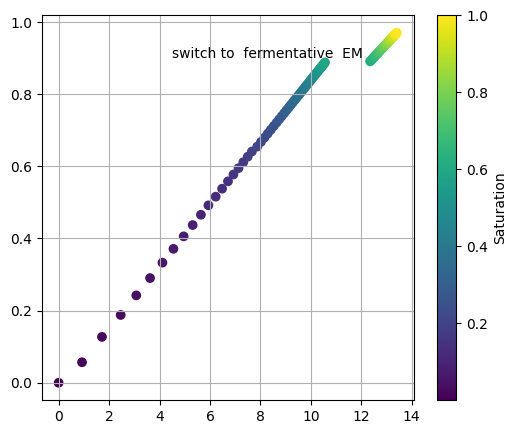

In [6]:
v1='GLCptspp'
v2='RBIO'

v1_ar=[sol.fluxes[v1] for sol in sols]
v2_ar=[sol.fluxes[v2] for sol in sols]

fig,ax,=plt.subplots(figsize=(6,5))
scatter=ax.scatter(v1_ar,v2_ar,c=np.array(kapps)/k_cat_up)
ax.grid()
ax.annotate("switch to  fermentative  EM", xy=(10.5, 0.7), xytext=(4.5, 0.9))
#ax.arrow(x=10,y=1,dx=0.5,dy=-0.05,width=0.02)
cb=plt.colorbar(scatter)
cb.set_label('Saturation')

We note that while in satFBA optimal solutions are elementary flux modes (EFMs), in standard FBA they are instead combinations of EFMs. We validate this by repeating the process, this time simply changinf the lower bound of the glucose exchange 

In [12]:

kapp_df_w_up=kapp_df.copy()
kapp_df_w_up.loc[len(kapp_df_w_up)]=['GLCptspp','fwd',k_cat_up,MW_up,0]
glucose_exchange_range=(sols[0].fluxes['EX_glc__D_e'],sols[-1].fluxes['EX_glc__D_e'])
exchange_lb,sols_fba=parametric_fba(model,rxn_id='EX_glc__D_e',bound_range=glucose_exchange_range,bound_type='lb',N=100,kapp_df=kapp_df_w_up,P_max=P_max_w_up)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\marco\anaconda3\envs\met_mod2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
100%|██████████| 100/100 [00:04<00:00, 20.57it/s]


[None, None]

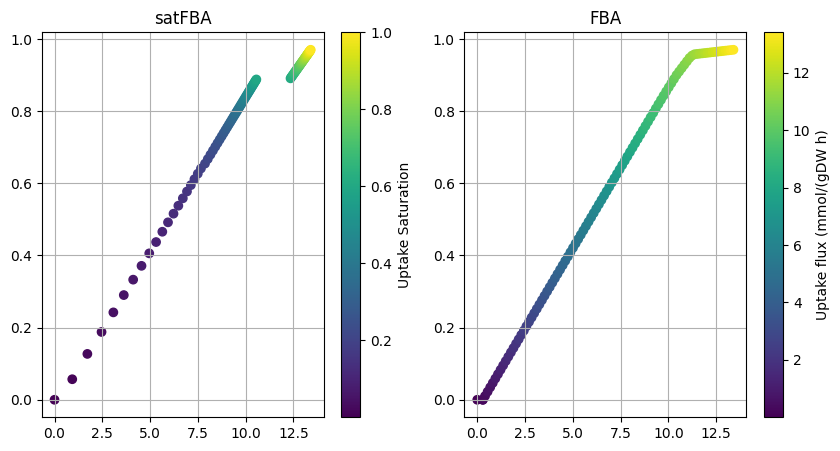

In [26]:
v1='GLCptspp'
v2='RBIO'

v1_ar_fba=[sol.fluxes[v1] for sol in sols_fba]
v2_ar_fba=[sol.fluxes[v2] for sol in sols_fba]

fig,ax,=plt.subplots(1,2,figsize=(10,5))
scatter_satfba=ax[0].scatter(v1_ar,v2_ar,c=np.array(kapps)/k_cat_up)
cb_satfba=plt.colorbar(scatter_satfba,ax=ax[0])
cb_satfba.set_label('Uptake Saturation')
ax[0].set_title('satFBA')

scatter_fba=ax[1].scatter(v1_ar_fba,v2_ar_fba,c=np.array(v1_ar_fba))
cb_fba=plt.colorbar(scatter_fba,ax=ax[1])
cb_fba.set_label('Uptake flux (mmol/(gDW h)')
ax[1].set_title('FBA')

[x.grid() for x in ax]


This is in agreement with the satFBA paper 